## Import requirements

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

## Setup Device-Agnostic code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Set the seed

In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

## Setting up Hyperparameters

In [4]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

## Image transformations

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # helps model to converge faster + make computations stable
])

## Importing dataset

In [6]:
train_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:18<00:00, 9.14MB/s]


In [7]:
len(train_dataset), len(test_dataset)

(50000, 10000)

## Conversion of datasets into dataloaders

In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f8295818b90>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8295c84830>)

In [10]:
len(train_loader), len(test_loader)

(391, 79)

## Building Vision Transformer Model

In [11]:
class PatchEmbedding(nn.Module):

  def __init__(self, img_size, patch_size, in_channels, embed_dim):
    super().__init__()
    self.patch_size = patch_size
    self.projection = nn.Conv2d(in_channels = in_channels,
                                out_channels=embed_dim,
                                kernel_size=patch_size,
                                stride=patch_size)

    num_patches = (img_size // patch_size) ** 2
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

  def forward(self, x:torch.Tensor):
    B = x.size(0)
    x = self.projection(x)
    x = x.flatten(2).transpose(1, 2)
    cls_token = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_token, x), dim=1)
    x = x + self.pos_embedding
    return x



In [12]:
class MLP(nn.Module):
  def __init__(self, in_features, hidden_features, drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features=in_features, out_features=hidden_features)
    self.fc2 = nn.Linear(in_features=hidden_features, out_features=in_features)
    self.dropout = nn.Dropout(drop_rate)

  def forward(self, x):
    x = self.dropout(f.gelu(self.fc1(x)))
    x = self.dropout(self.fc2(x))
    return x


In [13]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=drop_rate, batch_first=True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(in_features=embed_dim, hidden_features=mlp_dim, drop_rate=drop_rate)

  def forward(self, x):
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))
    return x

In [14]:
class VisionTransformer(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.patch_embedding = PatchEmbedding(img_size=img_size, patch_size=patch_size, in_channels=in_channels, embed_dim=embed_dim)
    self.encoder = nn.Sequential(*[
        TransformerEncoderLayer(embed_dim=embed_dim, num_heads=num_heads, mlp_dim=mlp_dim, drop_rate=drop_rate)
        for _ in range(depth)
        ])

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    x = self.patch_embedding(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    return self.head(cls_token)

In [15]:
# Instantiation of model
model = VisionTransformer(
    img_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    in_channels=CHANNELS,
    num_classes=NUM_CLASSES,
    embed_dim=EMBED_DIM,
    depth=DEPTH,
    num_heads=NUM_HEADS,
    mlp_dim=MLP_DIM,
    drop_rate=DROP_RATE
).to(device)

In [16]:
model

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (projection): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      

## Defining LOSS function

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [18]:
criterion

CrossEntropyLoss()

In [19]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

## Training

In [20]:
def train(model, loader, optimizer, criterion):
  # Set the model in training mode
  model.train()

  total_loss, correct = 0,0

  for x, y in loader:

    # moving data to target device
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()

    # Forward pass
    out = model(x)

    # Calculate loss
    loss = criterion(out, y)

    # Backward pass
    loss.backward()

    # Gradient descent
    optimizer.step()

    # Update metrics
    total_loss += loss.item() * x.size(0)
    correct += (out.argmax(1) == y).sum().item()

  return total_loss / len(loader.dataset), correct / len(loader.dataset) # Normalize the error


In [21]:
def evaluate(model, loader):
  model.eval()
  correct = 0

  with torch.inference_mode():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      out = model(x)
      correct += (out.argmax(1) == y).sum().item()

  return correct / len(loader.dataset)


## Train and Inference

In [22]:
from tqdm.auto import tqdm


In [23]:
train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  test_acc = evaluate(model, test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}%, Testing accuracy: {test_acc:.4f}%")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10, Train loss: 1.7331, Training accuracy: 0.3709%, Testing accuracy: 0.4769%
Epoch: 2/10, Train loss: 1.3789, Training accuracy: 0.5037%, Testing accuracy: 0.5309%
Epoch: 3/10, Train loss: 1.2319, Training accuracy: 0.5577%, Testing accuracy: 0.5631%
Epoch: 4/10, Train loss: 1.1242, Training accuracy: 0.5980%, Testing accuracy: 0.5967%
Epoch: 5/10, Train loss: 1.0407, Training accuracy: 0.6296%, Testing accuracy: 0.6120%
Epoch: 6/10, Train loss: 0.9643, Training accuracy: 0.6553%, Testing accuracy: 0.6150%
Epoch: 7/10, Train loss: 0.8893, Training accuracy: 0.6841%, Testing accuracy: 0.6292%
Epoch: 8/10, Train loss: 0.8163, Training accuracy: 0.7083%, Testing accuracy: 0.6331%
Epoch: 9/10, Train loss: 0.7480, Training accuracy: 0.7313%, Testing accuracy: 0.6244%
Epoch: 10/10, Train loss: 0.6754, Training accuracy: 0.7602%, Testing accuracy: 0.6398%


In [25]:
train_accuracies

[0.37086,
 0.50372,
 0.5577,
 0.59802,
 0.6296,
 0.65526,
 0.68412,
 0.7083,
 0.73134,
 0.76016]

In [26]:
test_accuracies

[0.4769, 0.5309, 0.5631, 0.5967, 0.612, 0.615, 0.6292, 0.6331, 0.6244, 0.6398]

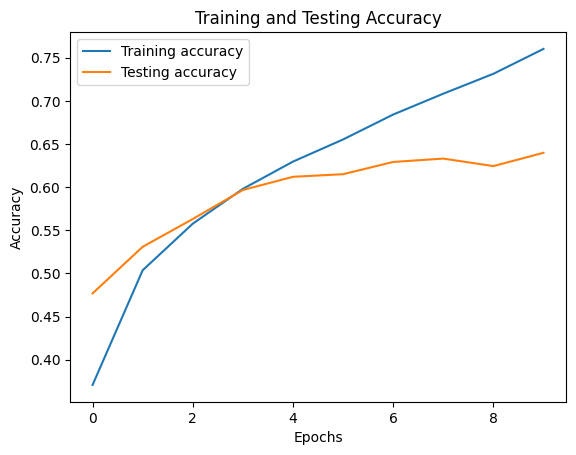

In [30]:
# Plot accuracies
plt.plot(train_accuracies, label="Training accuracy")
plt.plot(test_accuracies, label="Testing accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Testing Accuracy")
plt.show()

# Prediction

In [37]:
def predict_and_plot_grid(
    model,
    dataset,
    classes,
    grid_size = 3):
  model.eval()
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))

  for i in range(grid_size):
    for j in range(grid_size):
      idx = np.random.randint(0, len(dataset))
      img, true_label = dataset[idx]
      input_tensor = img.unsqueeze(0).to(device)

      with torch.inference_mode():
        output = model(input_tensor)
        _, predicted = torch.max(output.data, 1)

      img = img / 2 + 0.5 # Unnormalizing the image for plotting purpose
      npimg = img.cpu().numpy()
      axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
      truth = classes[true_label] == classes[predicted.item()]
      if truth:
        color = "g"
      else:
        color = "r"
      axes[i, j].set_title(f"True: {classes[true_label]}\nPredicted: {classes[predicted.item()]}", color=color)
      axes[i, j].axis("off")
  plt.tight_layout()
  plt.show()


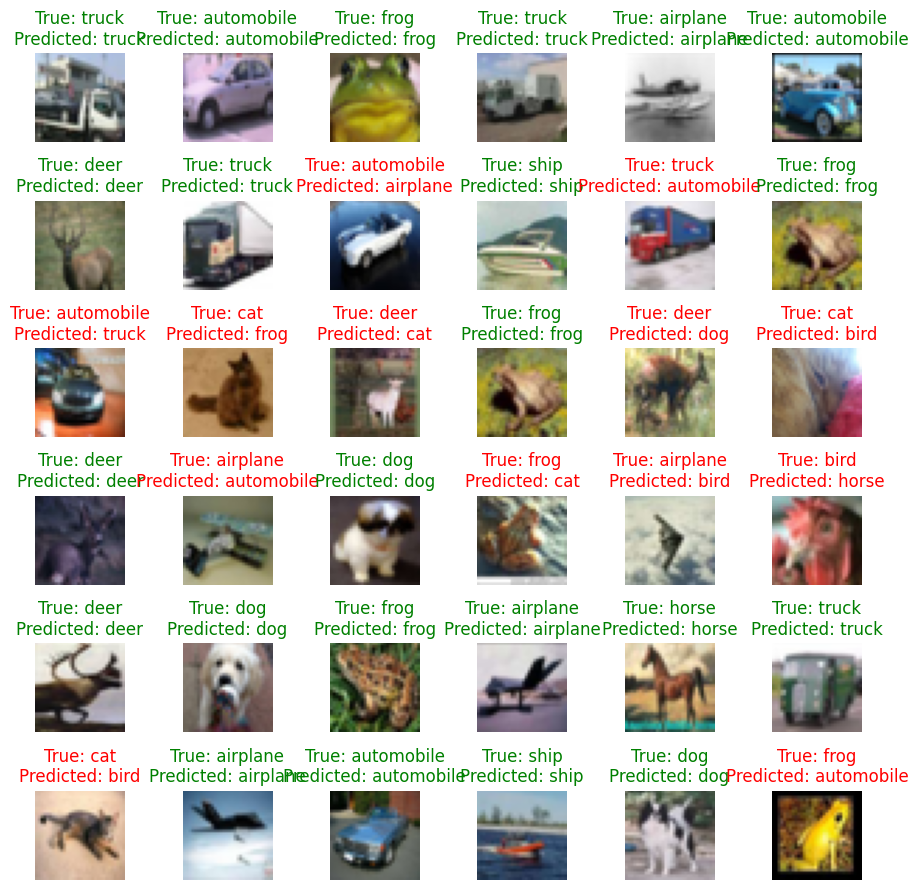

In [38]:
predict_and_plot_grid(model, test_dataset, train_dataset.classes, grid_size = 6)